# Welcome to the Tweet sentiment finder. In this notebook we track the overall sentiment for major current events.

Project by: Tahj Anderson, Jalen Barnes, Brady Jacobs, and Elena Le

In this notebook, we explore the question "Can Machines understand emotion in text?". Sentiment Analysis is the process of identifying and classifying opions expressed through text. In today's age, information is spread through text based mediums. For us humans to be able to understand vast ammounts of emotions, opinions, and gain a better understanding of how large groups of people feel about an event, computers can help us. This notebook focuses on the barebones of sentiment analysis and takes you though the steps to teach a computer how to understand english. 

Link to dataset: https://www.kaggle.com/datasets/kazanova/sentiment140

Import and download the needed libraries

In [ ]:
!pip install spacy
!pip install numpy
!pip install nltk
!pip install pandas
!pip install seaborn
!pip install matplotlib
!pip install scikit-learn

In [2]:
import re
import numpy as np
import pandas as pd
import nltk
# plotting
import seaborn as sns
import matplotlib.pyplot as plt
# nltk
from nltk.stem import WordNetLemmatizer
import spacy
# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from nltk.tokenize import RegexpTokenizer
from sklearn import preprocessing

#Sentiment finder
from textblob import TextBlob

Pull in the dataset

In [4]:
DATASET_ENCODING = "ISO-8859-1"
DATASET_COLUMNS=['target','ids','date','flag','user','tweet']
df = pd.read_csv('/content/sentiment140Cleaned.csv', encoding=DATASET_ENCODING, names=DATASET_COLUMNS)

df.tweet = df.tweet.astype(str) 
df['tweet']=df['tweet'].str.lower()
df.head()


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (1,2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,target,ids,date,flag,user,tweet
NaN,target,ids,date,flag,user,text
0.0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,awww bummer shoulda got david carr third day d
1.0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,upset update facebook texting might cry result...
2.0,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,dived many times ball managed save rest go bounds
3.0,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,whole body feels itchy like fire


In [5]:
data=df[['target','tweet']]
data['target'] = data['target'].replace(4,1)
data.head()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,target,tweet
NaN,target,text
0.0,0,awww bummer shoulda got david carr third day d
1.0,0,upset update facebook texting might cry result...
2.0,0,dived many times ball managed save rest go bounds
3.0,0,whole body feels itchy like fire


In [6]:
data_pos = data[data['target'] == 1]
data_neg = data[data['target'] == 0]

# Use these two lines to limit your data frame to any size you would like.
#data_pos = data_pos.iloc[:int (20000)]
#data_neg = data_neg.iloc[:int (20000)]

dataset = pd.concat([data_pos, data_neg])
dataset['tweet']=dataset['tweet'].str.lower()

dataset2 = dataset.copy()

At this step we tokenize the data. Tokenization is a fancy way of saying "splitting up the text" into seperate words.

In [7]:
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English
nlp = English()
tokenizer = Tokenizer(nlp.vocab)

def create_tokens(data):
  # The token.orth_ turns the type from spacy doc to normal string, this is important
  # because the stemmer can only work with string list
  tokens = [token.orth_ for token in tokenizer(data)]
  return tokens

dataset['tweet'] = dataset['tweet'].apply(lambda x: create_tokens(x))

In [53]:
dataset.head()

,target,tweet
800000.0,1,"[love, u, guys, r, best]"
800001.0,1,"[im, meeting, one, besties, tonight, cant, wai..."
800002.0,1,"[thanks, twitter, add, sunisa, got, meet, hin,..."
800003.0,1,"[sick, really, cheap, hurts, much, eat, real, ..."
800004.0,1,"[effect, everyone]"


Stemming is the process of reducing a word down to its stem. Here we use the Snowball Stemmer by NLTK

In [8]:
from nltk.stem.snowball import SnowballStemmer

def stemming_on_text(data):
  st = SnowballStemmer(language='english')
  text = [st.stem(word) for word in data]
  return text

dataset['tweet']= dataset['tweet'].apply(lambda x: stemming_on_text(x))




In [9]:
dataset.head()

,target,tweet
800000.0,1,"[love, u, guy, r, best]"
800001.0,1,"[im, meet, one, besti, tonight, cant, wait, gi..."
800002.0,1,"[thank, twitter, add, sunisa, got, meet, hin, ..."
800003.0,1,"[sick, realli, cheap, hurt, much, eat, real, f..."
800004.0,1,"[effect, everyon]"


Download to use the lemmatizer

In [10]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Lemmatizer processes words into groups based on different inflected forms of a word so the word can be analyzed as a single item. 

In [11]:
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data

dataset['tweet'] = dataset['tweet'].apply(lambda x: lemmatizer_on_text(x))
print(dataset['tweet'].head())

tweet_list = dataset['tweet']
dataset["tweet"] = dataset["tweet"].astype(str)

800000.0                              [love, u, guy, r, best]
800001.0    [im, meet, one, besti, tonight, cant, wait, gi...
800002.0    [thank, twitter, add, sunisa, got, meet, hin, ...
800003.0    [sick, realli, cheap, hurt, much, eat, real, f...
800004.0                                    [effect, everyon]
Name: tweet, dtype: object


In [12]:
dataset.shape

(1468929, 2)

Hwere we break our text into test train split using sci-kit learn. We also use TFidVectorizer to break each word down into its own vector

In [13]:
X=dataset.tweet
y=dataset.target

y = y.astype('int')

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.05, random_state =15105123)
print(X_train.dtype)

vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

object


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


No. of feature_words:  500000


In [14]:
def model_Evaluate(model):
    #enc = preprocessing.LabelEncoder()
    #y_test_encoded = enc.fit_transform(y_test)
    # Predict values for Test dataset
    y_pred = model.predict(X_test)
    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    #Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
    xticklabels = categories, yticklabels = categories)
    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

In [61]:
import scipy

In [ ]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier()
classifier.fit(X_train, y_train)
model_Evaluate(classifier)

In [ ]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(max_depth=7, n_estimators=10000).fit(X_train, y_train)
prediction = xgb_model.predict(X_test)
model_Evaluate(xgb_model)

KeyboardInterrupt: ignored

In [15]:
#SVCMODEL
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)
y_pred = SVCmodel.predict(X_test)

KeyboardInterrupt: ignored

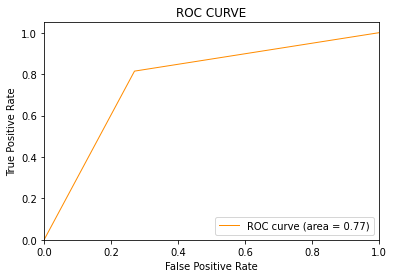

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

In [ ]:
import pickle
# pickling the vectorizer
pickle.dump(vectoriser, open('vectorizer.sav', 'wb'))
# pickling the model
pickle.dump(SVCmodel, open('SVCclassifier.sav', 'wb'))

              precision    recall  f1-score   support

           0       0.77      0.72      0.75     33557
           1       0.78      0.82      0.80     39890

    accuracy                           0.78     73447
   macro avg       0.78      0.77      0.77     73447
weighted avg       0.78      0.78      0.78     73447



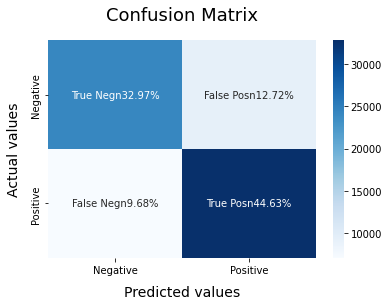

In [ ]:
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)
y_pred2 = BNBmodel.predict(X_test)

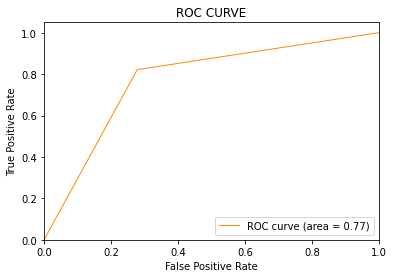

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred2)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

In [ ]:
import pickle
# pickling the model
pickle.dump(BNBmodel, open('BNBclassifier.sav', 'wb'))

              precision    recall  f1-score   support

           0       0.79      0.74      0.76     33779
           1       0.79      0.83      0.81     39668

    accuracy                           0.79     73447
   macro avg       0.79      0.78      0.79     73447
weighted avg       0.79      0.79      0.79     73447




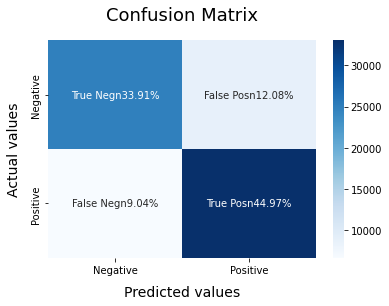

In [16]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)
y_pred3 = LRmodel.predict(X_test)
print()

In [17]:
import pickle
# pickling the vectorizer
pickle.dump(vectoriser, open('vectorizer.sav', 'wb'))
# pickling the model
pickle.dump(LRmodel, open('classifier.sav', 'wb'))

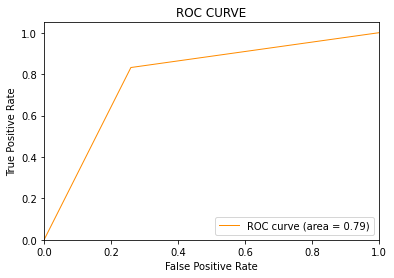

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred3)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

# Model Use example

In this section we use our new models on raw twitter data and explore use cases of the model.

Here we authenticate our twitter api service credentials

In [18]:
!pip install tweepy

In [23]:
import tweepy
from tweepy import OAuthHandler
import sys
#client = tweepy.Client("")
import configparser
config = configparser.ConfigParser()
config.read('/content/config.ini')

api_key = config['twitter']['api_key']
api_key_secret = config['twitter']['api_key_secret']

access_token = config['twitter']['access_token']
access_token_secret = config['twitter']['access_token_secret']

auth = tweepy.AppAuthHandler(api_key, api_key_secret)
#auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

In [24]:
# Verify the api connection worked
if (not api):
    print ("Can’t Authenticate")
    sys.exit(-1)

In [25]:
def pull_by_topic(topic):
    tweet_lst2=[]
    for tweet in tweepy.Cursor(api.search_tweets, q='Danny Green -filter:retweets').items(1000):
        if tweet.lang == "en":
            tweetDate = tweet.created_at.date()
            tweet_lst2.append([tweetDate,tweet.id,
                    tweet.user.screen_name,
                    tweet.user.name, tweet.text,
                    ])
        
    tweet_df2 = pd.DataFrame(tweet_lst2, columns=['tweet_dt', 'id','username', 'name', 'tweet'])
    return tweet_df2

In [26]:
def clean_tweets(txt):
    hashtagPattern = re.compile("#\w+")
    mentionPattern = re.compile("@\w+")
    txt = re.sub(hashtagPattern, "", str(txt))
    txt = re.sub(mentionPattern, "", str(txt))
    
    txt = " ".join(txt.split())
    
    return txt

In [29]:
# Testing our model in the field
def find_sentiment(df):
    #vectorizer = pickle.load(open('models/vectorizer.sav', 'rb'))
    #classifier = pickle.load(open('models/SVCclassifier.sav', 'rb'))
    classifier = LRmodel

    df['tweet'] = df['tweet'].apply(clean_tweets)

    cleanedText = []
    for text in df["tweet"]:
    # preprocess to remove unwanted
        text = clean.kitchen_sink(text)
        cleanedText.append(text)
    
    df.loc[:, "tweet"] = cleanedText
    #print(df.head())
    sentiment_df = pd.DataFrame(columns = ["text", "sentiment"])
    sentiment_arrays = []
    for text in df["tweet"]:
        #sentiment_df["text"] = text
        text_vector = vectorizer.transform([text])
        result = classifier.predict(text_vector)
        #sentiment_df["sentiment"] = result
        sentiment_arrays.append(result)
    
    sen_df = pd.DataFrame(sum(map(list, sentiment_arrays), []))
    df["sentiment"] = sen_df[0]
    return df